In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from datetime import datetime
from google.colab import files

In [3]:

# Set random seed to ensure reproducible results
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Load and preprocess data
print("Loading data...")
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

Loading data...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Define 10 experiment configurations
configs = [
    # Configuration 1: Baseline configuration
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'baseline'},

    # Configuration 2-4: Optimizer variations
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'rmsprop',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adamw',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer'},

    # Configuration 5-6: Learning rate variations
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.01, 'experiment_group': 'learning_rate'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.0001, 'experiment_group': 'learning_rate'},

    # Configuration 7-8: Network width variations
    {'filters': 32, 'kernel_size': 5, 'dense_units': 64, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width'},
    {'filters': 128, 'kernel_size': 5, 'dense_units': 256, 'optimizer': 'adam',
     'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width'},

    # Configuration 9-10: Batch size variations
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 32, 'learning_rate': 0.001, 'experiment_group': 'batch_size'},
    {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam',
     'batch_size': 128, 'learning_rate': 0.001, 'experiment_group': 'batch_size'},
]

In [6]:
# Add epochs parameter for each configuration
for cfg in configs:
    cfg['epochs'] = 5  # All configurations use the same number of training epochs

# Print experiment plan
print(f"A total of {len(configs)} configurations will be tested:")
for i, cfg in enumerate(configs):
    print(f"{i+1}. Group: {cfg['experiment_group']} - {cfg}")

A total of 10 configurations will be tested:
1. Group: baseline - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'baseline', 'epochs': 5}
2. Group: optimizer - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'rmsprop', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
3. Group: optimizer - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
4. Group: optimizer - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adamw', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
5. Group: learning_rate - {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.01, 'experiment_group': 'learning_rate', 'epochs': 5}
6. Group: learning_rat

In [7]:
# Training function
def train_model(config, x_train, y_train, x_test, y_test):
    model = models.Sequential([
        layers.Input(shape=x_train.shape[1:]),
        layers.Conv2D(config['filters'], (config['kernel_size'], config['kernel_size']),
                     activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(config['dense_units'], activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    # Set optimizer
    if config['optimizer'] == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=config['learning_rate'])
    else:
        raise ValueError(f"Unsupported optimizer: {config['optimizer']}")

    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    print(f"\nTraining configuration: {config}")

    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_split=0.1,
        verbose=1
    )
    end_time = time.time()
    duration = round(end_time - start_time, 2)

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    return {
        'config': config,
        'test_accuracy': test_acc,
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'training_time_sec': duration,
        'history': history.history
    }


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'baseline', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 93ms/step - accuracy: 0.8089 - loss: 0.5420 - val_accuracy: 0.8805 - val_loss: 0.3341
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.8975 - loss: 0.2832 - val_accuracy: 0.8982 - val_loss: 0.2844
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.9170 - loss: 0.2301 - val_accuracy: 0.9068 - val_loss: 0.2676
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 71s 84ms/step - accuracy: 0.9303 - loss: 0.1910 - val_accuracy: 0.9107 - val_loss: 0.2568
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 85s 88ms/step - accuracy: 0.9430 - loss: 0.1580 - val_accuracy: 0.9110 - val_loss: 0.2668
Test accuracy: 0.9065


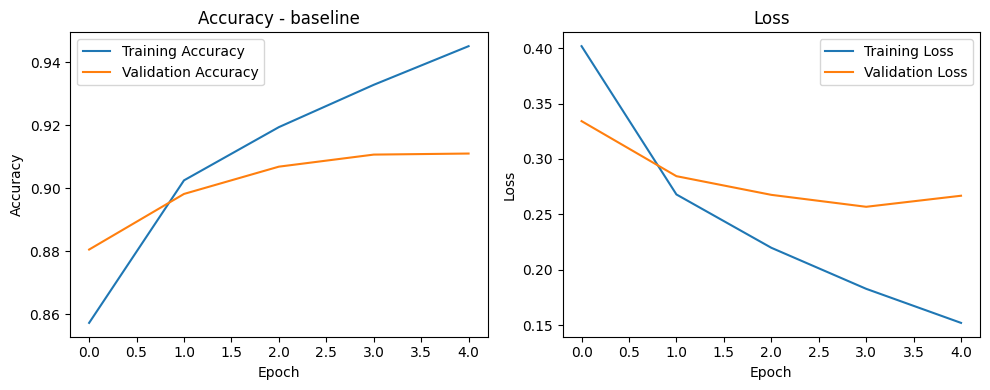


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'rmsprop', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 73s 85ms/step - accuracy: 0.7953 - loss: 0.5791 - val_accuracy: 0.8852 - val_loss: 0.3074
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - accuracy: 0.8958 - loss: 0.2892 - val_accuracy: 0.9033 - val_loss: 0.2682
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 69s 82ms/step - accuracy: 0.9147 - loss: 0.2342 - val_accuracy: 0.9118 - val_loss: 0.2515
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.9282 - loss: 0.1967 - val_accuracy: 0.9160 - val_loss: 0.2487
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 80ms/step - accuracy: 0.9407 - loss: 0.1649 - val_accuracy: 0.9155 - val_loss: 0.2557
Test accuracy: 0.9115


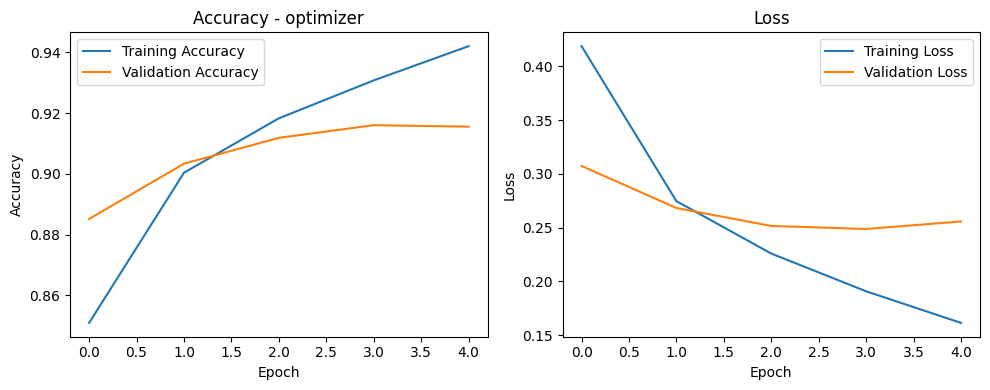


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'sgd', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 68s 80ms/step - accuracy: 0.3842 - loss: 2.0719 - val_accuracy: 0.6753 - val_loss: 1.1633
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 82ms/step - accuracy: 0.6740 - loss: 1.0401 - val_accuracy: 0.7272 - val_loss: 0.7941
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 84s 84ms/step - accuracy: 0.7329 - loss: 0.7807 - val_accuracy: 0.7560 - val_loss: 0.6937
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 78s 79ms/step - accuracy: 0.7632 - loss: 0.6935 - val_accuracy: 0.7740 - val_loss: 0.6410
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 78ms/step - accuracy: 0.7806 - loss: 0.6436 - val_accuracy: 0.7857 - val_loss: 0.6056
Test accuracy: 0.7783


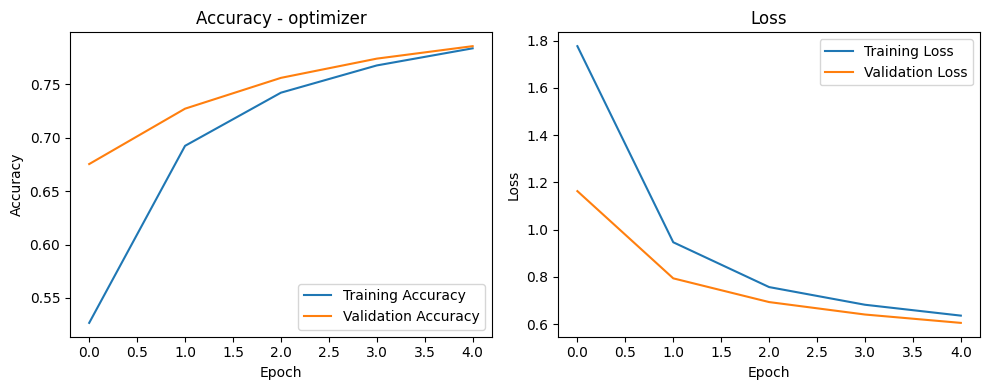


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adamw', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'optimizer', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - accuracy: 0.8059 - loss: 0.5458 - val_accuracy: 0.8797 - val_loss: 0.3305
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.8950 - loss: 0.2893 - val_accuracy: 0.8948 - val_loss: 0.2950
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 75s 88ms/step - accuracy: 0.9140 - loss: 0.2349 - val_accuracy: 0.9032 - val_loss: 0.2824
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 77s 91ms/step - accuracy: 0.9292 - loss: 0.1968 - val_accuracy: 0.9100 - val_loss: 0.2672
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.9399 - loss: 0.1647 - val_accuracy: 0.9128 - val_loss: 0.2594
Test accuracy: 0.9098


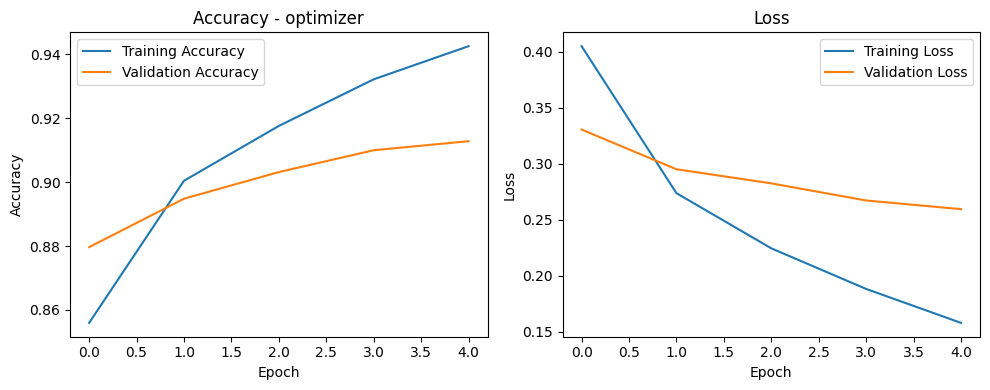


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.01, 'experiment_group': 'learning_rate', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 73s 85ms/step - accuracy: 0.8101 - loss: 0.5554 - val_accuracy: 0.8822 - val_loss: 0.3305
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 72s 85ms/step - accuracy: 0.8878 - loss: 0.3031 - val_accuracy: 0.8923 - val_loss: 0.3049
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 72s 86ms/step - accuracy: 0.9055 - loss: 0.2554 - val_accuracy: 0.8917 - val_loss: 0.3078
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 84ms/step - accuracy: 0.9169 - loss: 0.2248 - val_accuracy: 0.8885 - val_loss: 0.3526
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - accuracy: 0.9195 - loss: 0.2146 - val_accuracy: 0.8815 - val_loss: 0.4207
Test accuracy: 0.8746


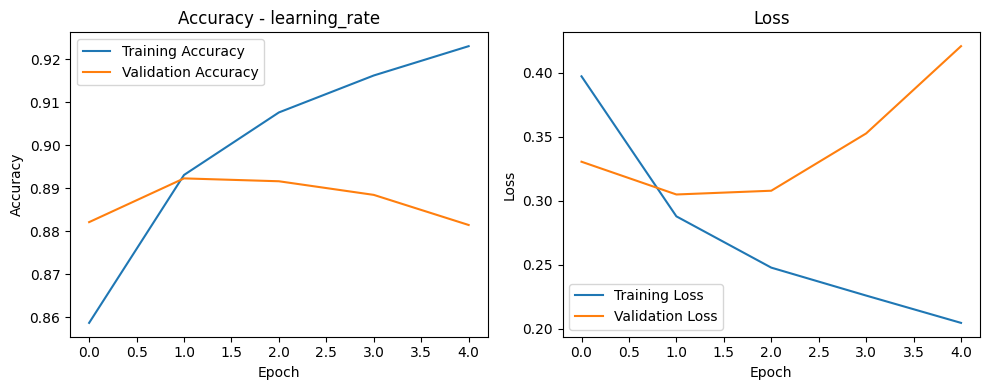


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.0001, 'experiment_group': 'learning_rate', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 94ms/step - accuracy: 0.7259 - loss: 0.8389 - val_accuracy: 0.8403 - val_loss: 0.4590
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 92ms/step - accuracy: 0.8553 - loss: 0.4185 - val_accuracy: 0.8630 - val_loss: 0.3892
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 80s 90ms/step - accuracy: 0.8712 - loss: 0.3687 - val_accuracy: 0.8752 - val_loss: 0.3532
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 91ms/step - accuracy: 0.8819 - loss: 0.3375 - val_accuracy: 0.8835 - val_loss: 0.3306
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.8893 - loss: 0.3143 - val_accuracy: 0.8917 - val_loss: 0.3145
Test accuracy: 0.8838


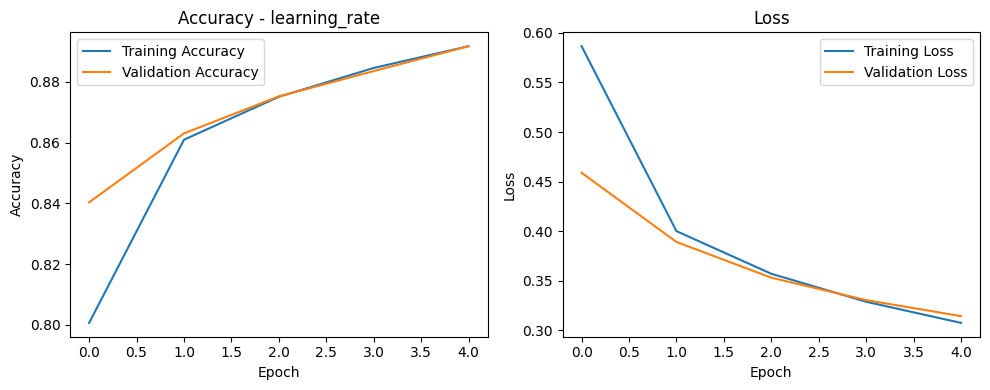


Training configuration: {'filters': 32, 'kernel_size': 5, 'dense_units': 64, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - accuracy: 0.7949 - loss: 0.5997 - val_accuracy: 0.8775 - val_loss: 0.3461
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - accuracy: 0.8894 - loss: 0.3060 - val_accuracy: 0.8955 - val_loss: 0.2970
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9073 - loss: 0.2580 - val_accuracy: 0.9037 - val_loss: 0.2732
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.9199 - loss: 0.2247 - val_accuracy: 0.9088 - val_loss: 0.2610
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.9286 - loss: 0.1981 - val_accuracy: 0.9120 - val_loss: 0.2587
Test accuracy: 0.9051


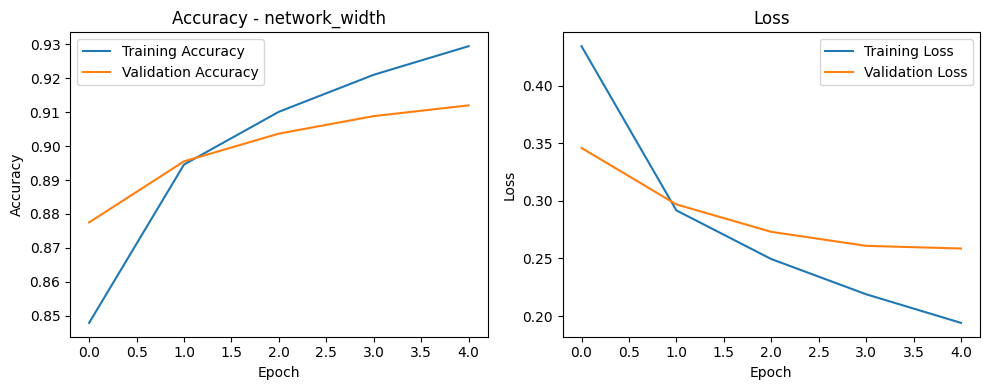


Training configuration: {'filters': 128, 'kernel_size': 5, 'dense_units': 256, 'optimizer': 'adam', 'batch_size': 64, 'learning_rate': 0.001, 'experiment_group': 'network_width', 'epochs': 5}
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 175s 206ms/step - accuracy: 0.8222 - loss: 0.4920 - val_accuracy: 0.8850 - val_loss: 0.3158
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 170s 201ms/step - accuracy: 0.9045 - loss: 0.2644 - val_accuracy: 0.8958 - val_loss: 0.2904
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 200s 199ms/step - accuracy: 0.9249 - loss: 0.2058 - val_accuracy: 0.9042 - val_loss: 0.2718
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 171s 202ms/step - accuracy: 0.9420 - loss: 0.1592 - val_accuracy: 0.9045 - val_loss: 0.3004
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 201s 201ms/step - accuracy: 0.9567 - loss: 0.1212 - val_accuracy: 0.9110 - val_loss: 0.2804
Test accuracy: 0.9107


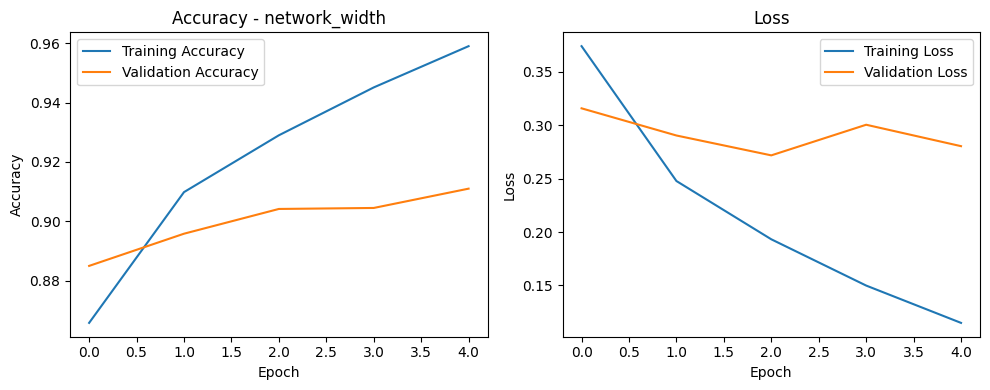


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 32, 'learning_rate': 0.001, 'experiment_group': 'batch_size', 'epochs': 5}
Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 103s 60ms/step - accuracy: 0.8164 - loss: 0.5088 - val_accuracy: 0.8895 - val_loss: 0.3053
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 97s 57ms/step - accuracy: 0.9009 - loss: 0.2723 - val_accuracy: 0.9045 - val_loss: 0.2653
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 96s 57ms/step - accuracy: 0.9214 - loss: 0.2156 - val_accuracy: 0.9082 - val_loss: 0.2587
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 142s 57ms/step - accuracy: 0.9361 - loss: 0.1742 - val_accuracy: 0.9118 - val_loss: 0.2687
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 147s 60ms/step - accuracy: 0.9498 - loss: 0.1374 - val_accuracy: 0.9095 - val_loss: 0.2787
Test accuracy: 0.9105


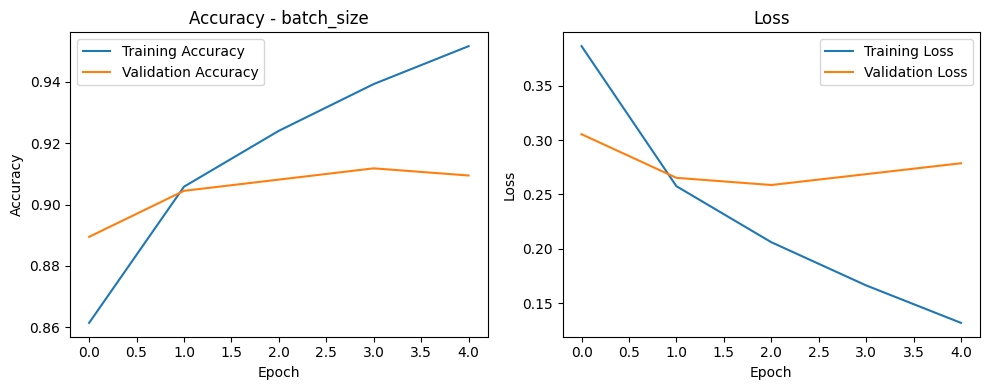


Training configuration: {'filters': 64, 'kernel_size': 5, 'dense_units': 128, 'optimizer': 'adam', 'batch_size': 128, 'learning_rate': 0.001, 'experiment_group': 'batch_size', 'epochs': 5}
Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 71s 166ms/step - accuracy: 0.7869 - loss: 0.6023 - val_accuracy: 0.8865 - val_loss: 0.3198
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 165ms/step - accuracy: 0.8909 - loss: 0.3064 - val_accuracy: 0.8970 - val_loss: 0.2882
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 166ms/step - accuracy: 0.9084 - loss: 0.2526 - val_accuracy: 0.9062 - val_loss: 0.2647
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 69s 163ms/step - accuracy: 0.9219 - loss: 0.2153 - val_accuracy: 0.9142 - val_loss: 0.2476
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - accuracy: 0.9331 - loss: 0.1849 - val_accuracy: 0.9122 - val_loss: 0.2450
Test accuracy: 0.9093


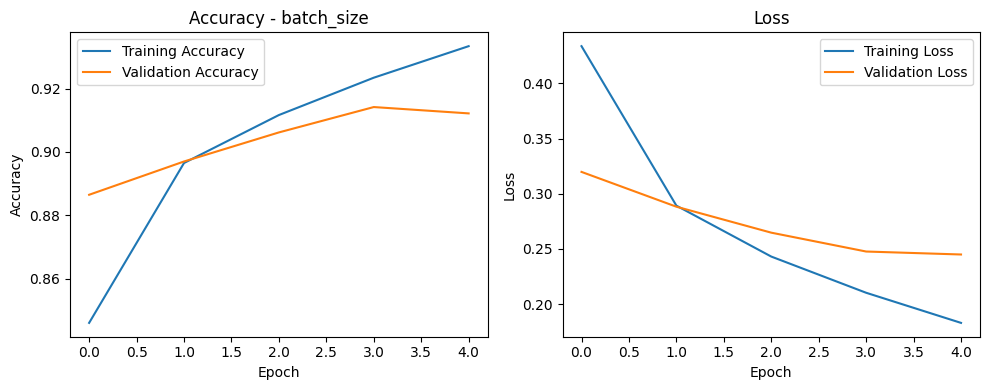

In [8]:
# Execute experiments
results = []

for config in configs:
    result = train_model(config, x_train, y_train, x_test, y_test)
    results.append(result)

    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(result['train_accuracy'], label='Training Accuracy')
    plt.plot(result['val_accuracy'], label='Validation Accuracy')
    plt.title(f"Accuracy - {config['experiment_group']}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(result['history']['loss'], label='Training Loss')
    plt.plot(result['history']['val_loss'], label='Validation Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

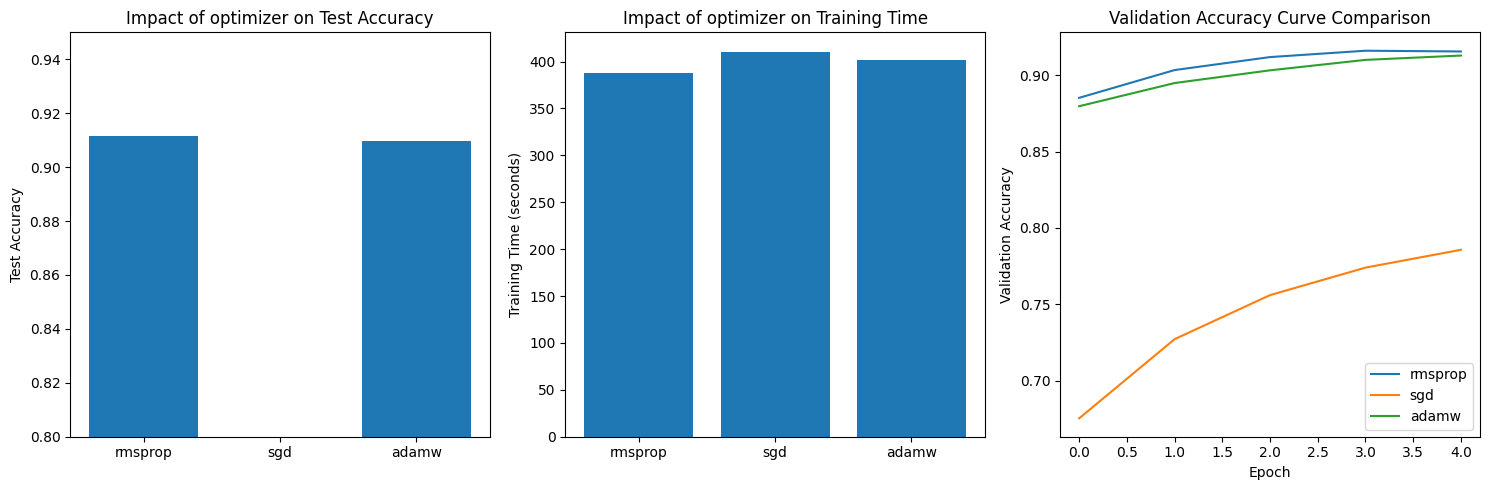

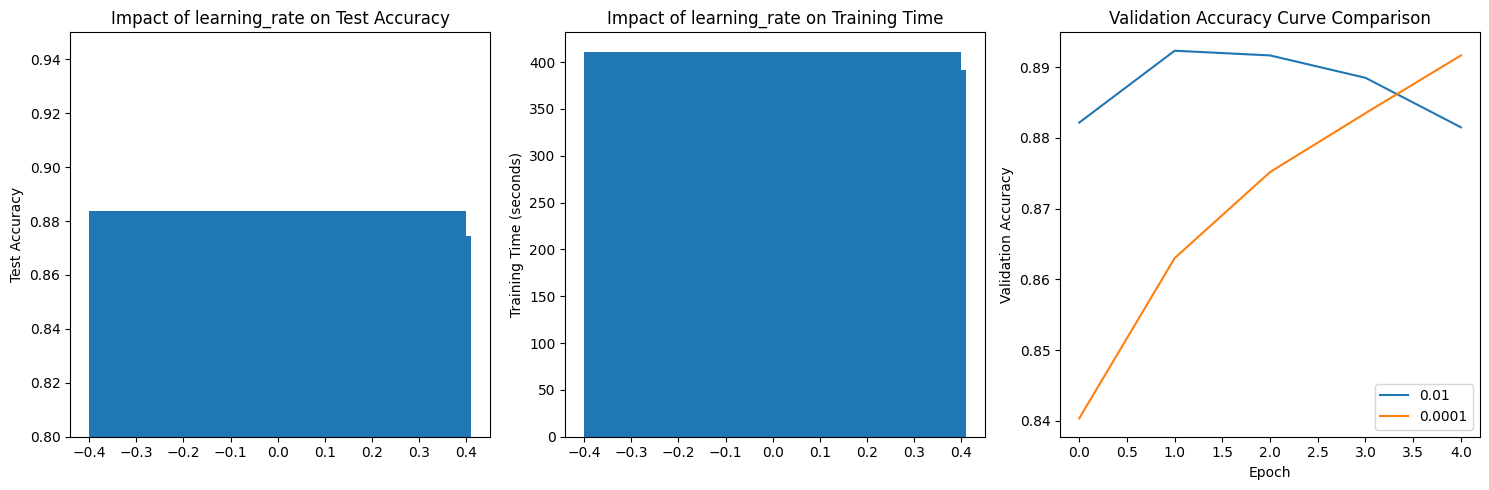

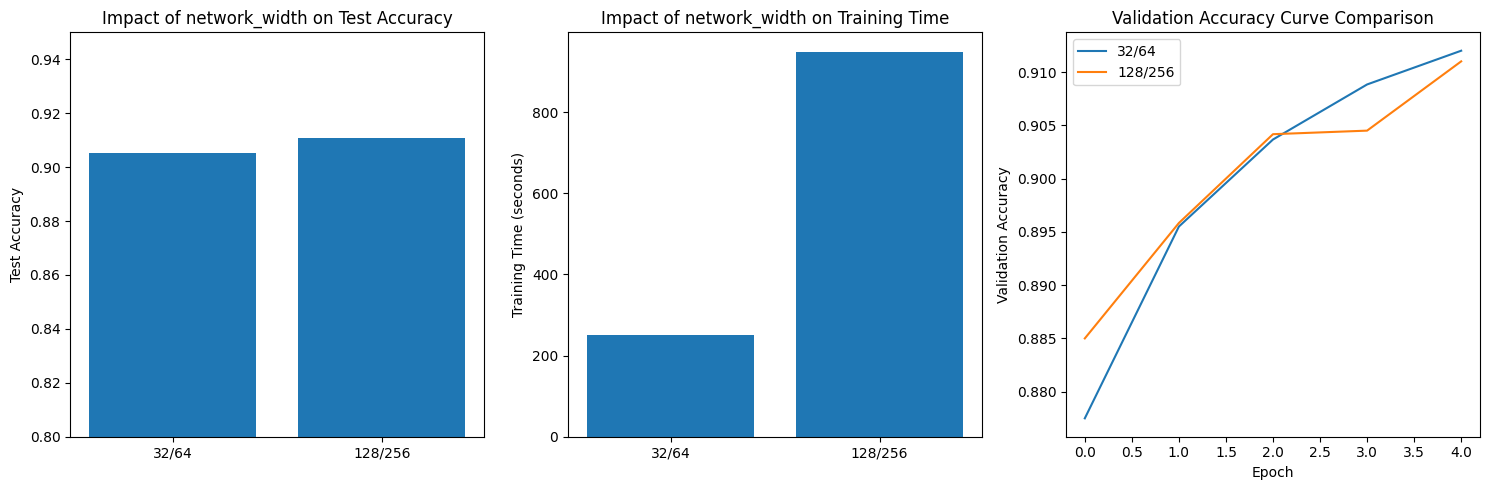

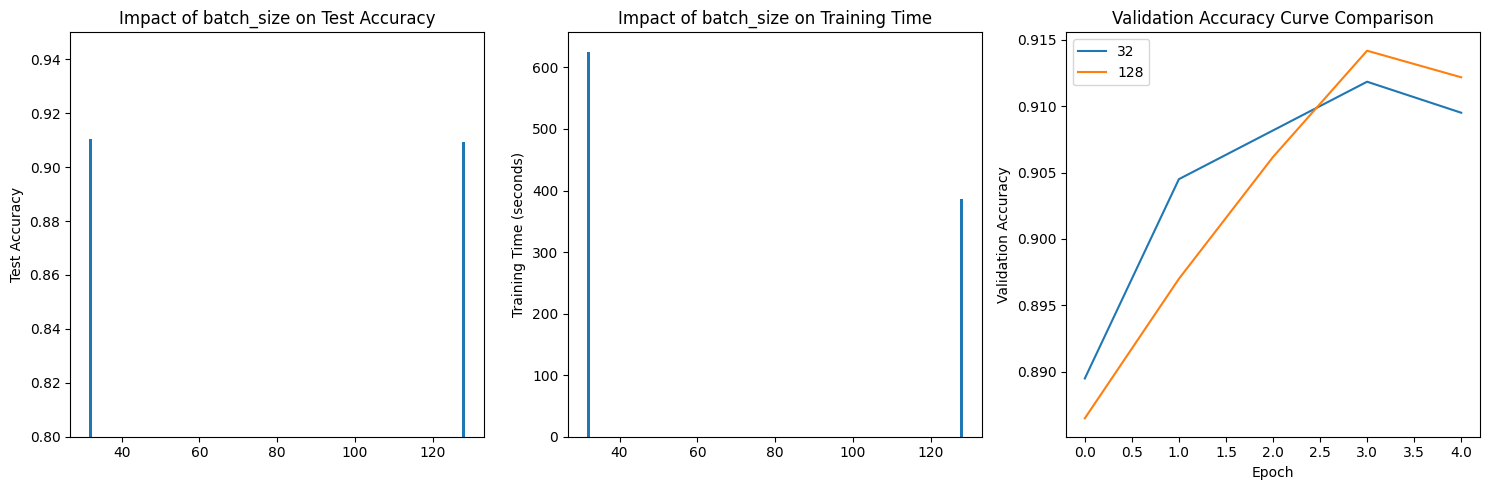

In [10]:
# Organize results by experiment group
groups = {}
for r in results:
    group = r['config']['experiment_group']
    if group not in groups:
        groups[group] = []
    groups[group].append(r)

# Create comparison charts for each experiment group
# Only process groups with multiple configurations
for group_name, group_results in groups.items():
    if group_name == 'baseline' or len(group_results) <= 1:
        continue

    plt.figure(figsize=(15, 5))

    # Test accuracy comparison
    plt.subplot(1, 3, 1)
    param_values = []
    accuracies = []

    for r in group_results:
        if group_name == 'optimizer':
            param_values.append(r['config']['optimizer'])
        elif group_name == 'learning_rate':
            param_values.append(r['config']['learning_rate'])
        elif group_name == 'batch_size':
            param_values.append(r['config']['batch_size'])
        elif group_name == 'network_width':
            param_values.append(f"{r['config']['filters']}/{r['config']['dense_units']}")

        accuracies.append(r['test_accuracy'])

    plt.bar(param_values, accuracies)
    plt.title(f"Impact of {group_name} on Test Accuracy")
    plt.ylabel("Test Accuracy")
    plt.ylim(0.8, 0.95)  # Adjust Y-axis range to highlight differences

    # Training time comparison
    plt.subplot(1, 3, 2)
    train_times = [r['training_time_sec'] for r in group_results]
    plt.bar(param_values, train_times)
    plt.title(f"Impact of {group_name} on Training Time")
    plt.ylabel("Training Time (seconds)")

    # Training curve comparison
    plt.subplot(1, 3, 3)
    for i, r in enumerate(group_results):
        label = param_values[i]
        plt.plot(r['val_accuracy'], label=f"{label}")
    plt.title("Validation Accuracy Curve Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
# Create results summary table
summary = []
for r in results:
    cfg = r['config']
    summary.append({
        'Experiment Group': cfg['experiment_group'],
        'Optimizer': cfg['optimizer'],
        'Learning Rate': cfg['learning_rate'],
        'Batch Size': cfg['batch_size'],
        'Filters': cfg['filters'],
        'Dense Units': cfg['dense_units'],
        'Kernel Size': cfg['kernel_size'],
        'Training Time (sec)': r['training_time_sec'],
        'Training Accuracy (final)': round(r['train_accuracy'][-1], 4),
        'Validation Accuracy (final)': round(r['val_accuracy'][-1], 4),
        'Test Accuracy': round(r['test_accuracy'], 4),
        'Overfitting Degree': round(r['train_accuracy'][-1] - r['val_accuracy'][-1], 4)
    })

summary_df = pd.DataFrame(summary)
print("\nModel Configuration Summary Table:")
display(summary_df)

# Sort by test accuracy
sorted_df = summary_df.sort_values('Test Accuracy', ascending=False)
print("\nConfigurations Sorted by Test Accuracy:")
display(sorted_df)

# Save to CSV and provide download
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"model_summary_{timestamp}.csv"
sorted_df.to_csv(filename, index=False)
files.download(filename)


Model Configuration Summary Table:


Experiment Group Optimizer  Learning Rate  Batch Size  Filters  Dense Units  \
0         baseline      adam         0.0010          64       64          128   
1        optimizer   rmsprop         0.0010          64       64          128   
2        optimizer       sgd         0.0010          64       64          128   
3        optimizer     adamw         0.0010          64       64          128   
4    learning_rate      adam         0.0100          64       64          128   
5    learning_rate      adam         0.0001          64       64          128   
6    network_width      adam         0.0010          64       32           64   
7    network_width      adam         0.0010          64      128          256   
8       batch_size      adam         0.0010          32       64          128   
9       batch_size      adam         0.0010         128       64          128   

   Kernel Size  Training Time (sec)  Training Accuracy (final)  \
0            5               396.15                     0.9451   
1            5               388.19                     0.9420   
2            5               410.65                     0.7836   
3            5               401.44                     0.9426   
4            5               391.71                     0.9231   
5            5               411.20                     0.8917   
6            5               249.65                     0.9294   
7            5               949.12                     0.9590   
8            5               625.75                     0.9517   
9            5               386.34                     0.9334   

   Validation Accuracy (final)  Test Accuracy  Overfitting Degree  
0                       0.9110         0.9065              0.0341  
1                       0.9155         0.9115              0.0265  
2                       0.7857         0.7783             -0.0020  
3                       0.9128         0.9098              0.0297  
4                       0.8815         0.8746              0.0416  
5                       0.8917         0.8838              0.0000  
6                       0.9120         0.9051              0.0174  
7                       0.9110         0.9107              0.0480  
8                       0.9095         0.9105              0.0422  
9                       0.9122         0.9093              0.0212


Configurations Sorted by Test Accuracy:


Experiment Group Optimizer  Learning Rate  Batch Size  Filters  Dense Units  \
1        optimizer   rmsprop         0.0010          64       64          128   
7    network_width      adam         0.0010          64      128          256   
8       batch_size      adam         0.0010          32       64          128   
3        optimizer     adamw         0.0010          64       64          128   
9       batch_size      adam         0.0010         128       64          128   
0         baseline      adam         0.0010          64       64          128   
6    network_width      adam         0.0010          64       32           64   
5    learning_rate      adam         0.0001          64       64          128   
4    learning_rate      adam         0.0100          64       64          128   
2        optimizer       sgd         0.0010          64       64          128   

   Kernel Size  Training Time (sec)  Training Accuracy (final)  \
1            5               388.19                     0.9420   
7            5               949.12                     0.9590   
8            5               625.75                     0.9517   
3            5               401.44                     0.9426   
9            5               386.34                     0.9334   
0            5               396.15                     0.9451   
6            5               249.65                     0.9294   
5            5               411.20                     0.8917   
4            5               391.71                     0.9231   
2            5               410.65                     0.7836   

   Validation Accuracy (final)  Test Accuracy  Overfitting Degree  
1                       0.9155         0.9115              0.0265  
7                       0.9110         0.9107              0.0480  
8                       0.9095         0.9105              0.0422  
3                       0.9128         0.9098              0.0297  
9                       0.9122         0.9093              0.0212  
0                       0.9110         0.9065              0.0341  
6                       0.9120         0.9051              0.0174  
5                       0.8917         0.8838              0.0000  
4                       0.8815         0.8746              0.0416  
2                       0.7857         0.7783             -0.0020

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

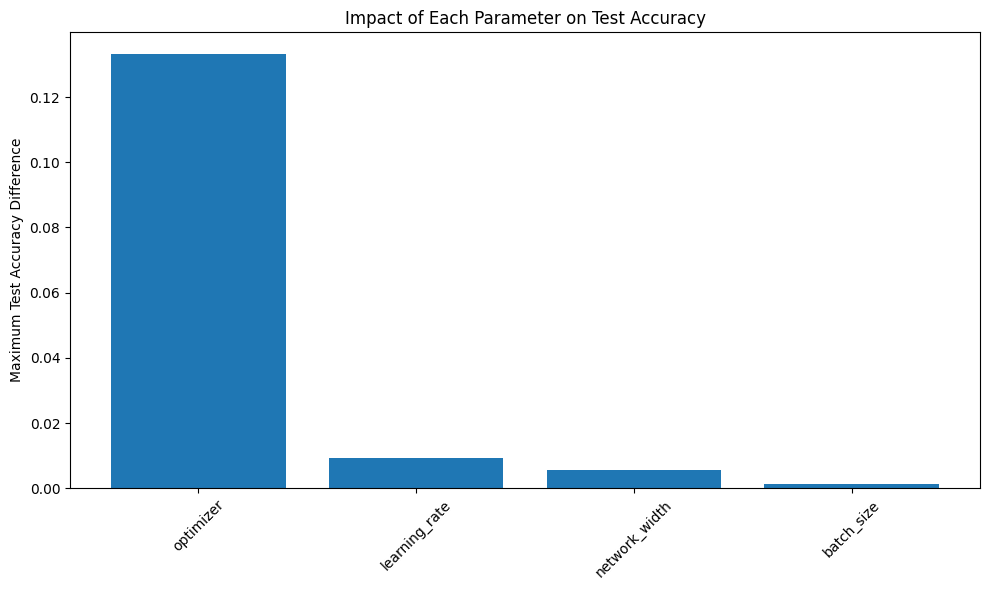

In [12]:
# Calculate and plot parameter importance
importance_data = {}

for group_name, group_results in groups.items():
    if group_name == 'baseline' or len(group_results) <= 1:
        continue

    accuracies = [r['test_accuracy'] for r in group_results]
    max_acc = max(accuracies)
    min_acc = min(accuracies)
    importance = max_acc - min_acc
    importance_data[group_name] = importance

# If there are enough groups to compare
if len(importance_data) > 1:
    plt.figure(figsize=(10, 6))
    groups = list(importance_data.keys())
    importances = list(importance_data.values())

    # Sort by importance
    sorted_indices = np.argsort(importances)[::-1]
    groups = [groups[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]

    plt.bar(groups, importances)
    plt.title("Impact of Each Parameter on Test Accuracy")
    plt.ylabel("Maximum Test Accuracy Difference")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Generating comparison plots by experiment group...


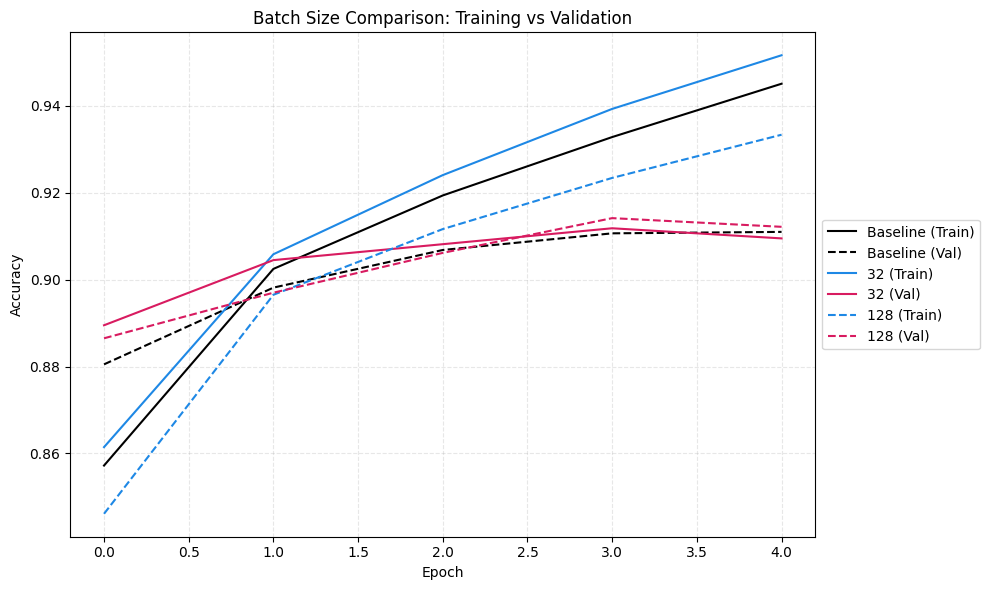

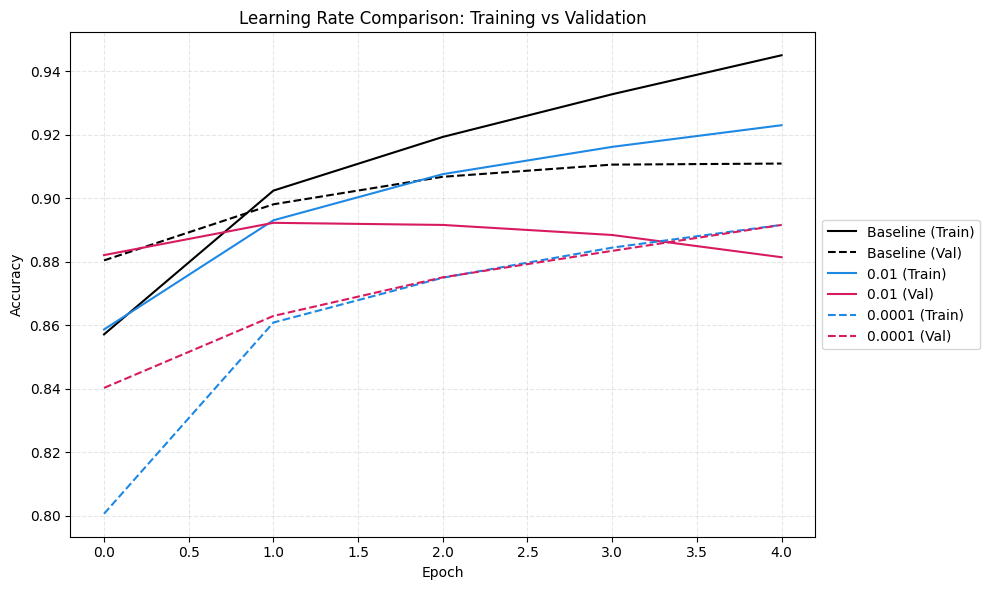

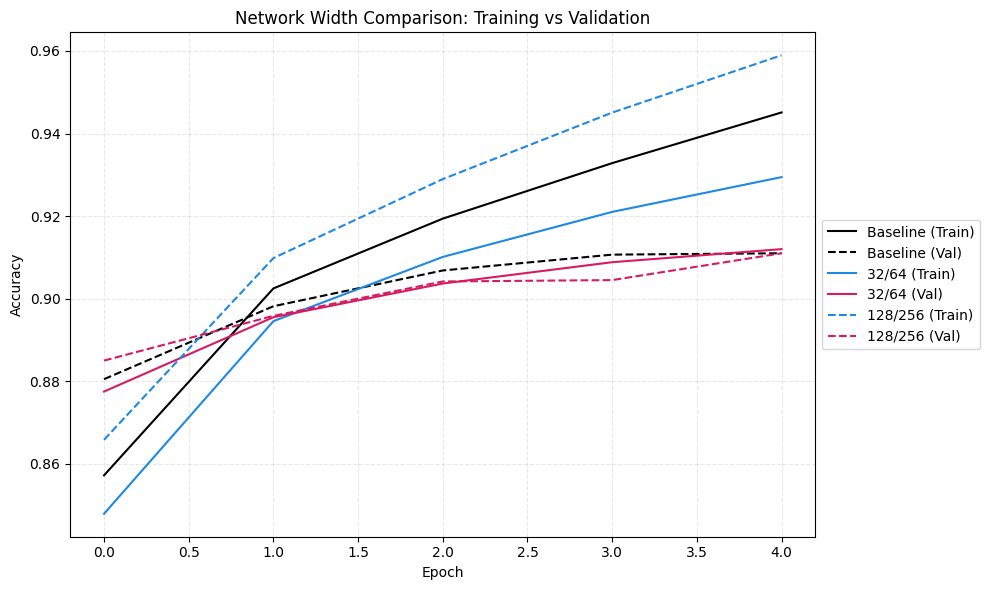

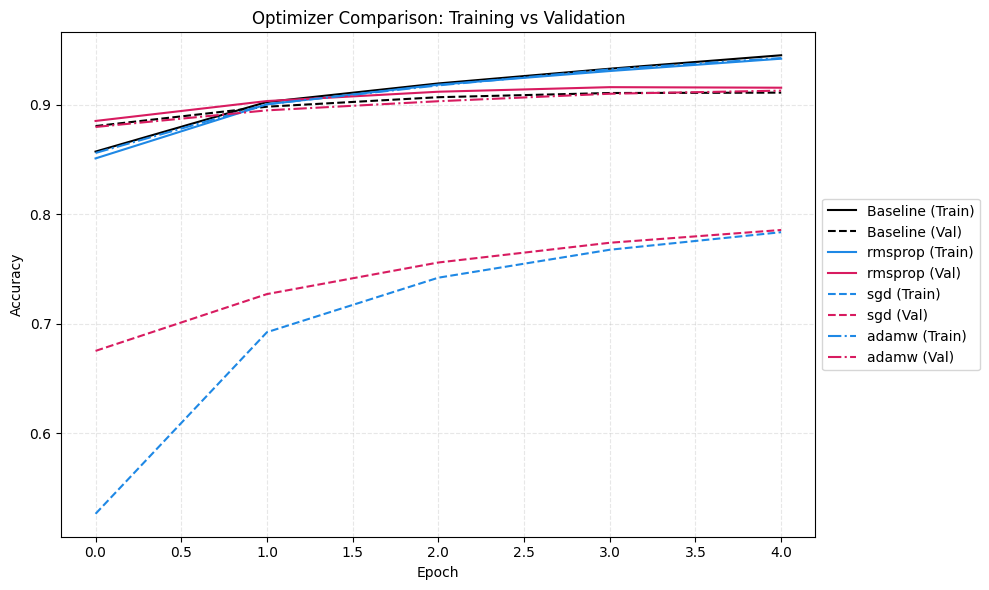

In [22]:
# Comparison of training and validation accuracy curves by experiment group on the same plot
print("\nGenerating comparison plots by experiment group...")

# Get unique experiment groups (excluding baseline)
unique_groups = set(r['config']['experiment_group'] for r in results)
if 'baseline' in unique_groups:
    unique_groups.remove('baseline')

# Get the baseline result for comparison
baseline_result = next((r for r in results if r['config']['experiment_group'] == 'baseline'), None)

# Color mapping for consistency
train_color = '#1E88E5'  # Blue for training data
val_color = '#D81B60'    # Red/magenta for validation data

# Line style variations for different experiments
line_styles = ['-', '--', '-.', ':']

# For each experiment group, create a combined plot (train+val on same axes)
for group_name in unique_groups:
    group_results = [r for r in results if r['config']['experiment_group'] == group_name]

    plt.figure(figsize=(10, 6))

    # First plot baseline for reference if available
    if baseline_result:
        plt.plot(baseline_result['train_accuracy'], 'k-', label="Baseline (Train)")
        plt.plot(baseline_result['val_accuracy'], 'k--', label="Baseline (Val)")

    # Then plot group results with training and validation on same plot
    for i, r in enumerate(group_results):
        # Get the parameter value for labeling
        param_value = ""
        if group_name == 'optimizer':
            param_value = r['config']['optimizer']
        elif group_name == 'learning_rate':
            param_value = str(r['config']['learning_rate'])
        elif group_name == 'batch_size':
            param_value = str(r['config']['batch_size'])
        elif group_name == 'network_width':
            param_value = f"{r['config']['filters']}/{r['config']['dense_units']}"

        # Select line style based on experiment index
        line_style = line_styles[i % len(line_styles)]

        # Plot both training and validation with same line style but different colors
        plt.plot(r['train_accuracy'],
                 color=train_color,
                 linestyle=line_style,
                 label=f"{param_value} (Train)")

        plt.plot(r['val_accuracy'],
                 color=val_color,
                 linestyle=line_style,
                 label=f"{param_value} (Val)")

    # Set title and labels
    plt.title(f"{group_name.replace('_', ' ').title()} Comparison: Training vs Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3)

    # Improve legend - place it outside to save space in the plot area
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

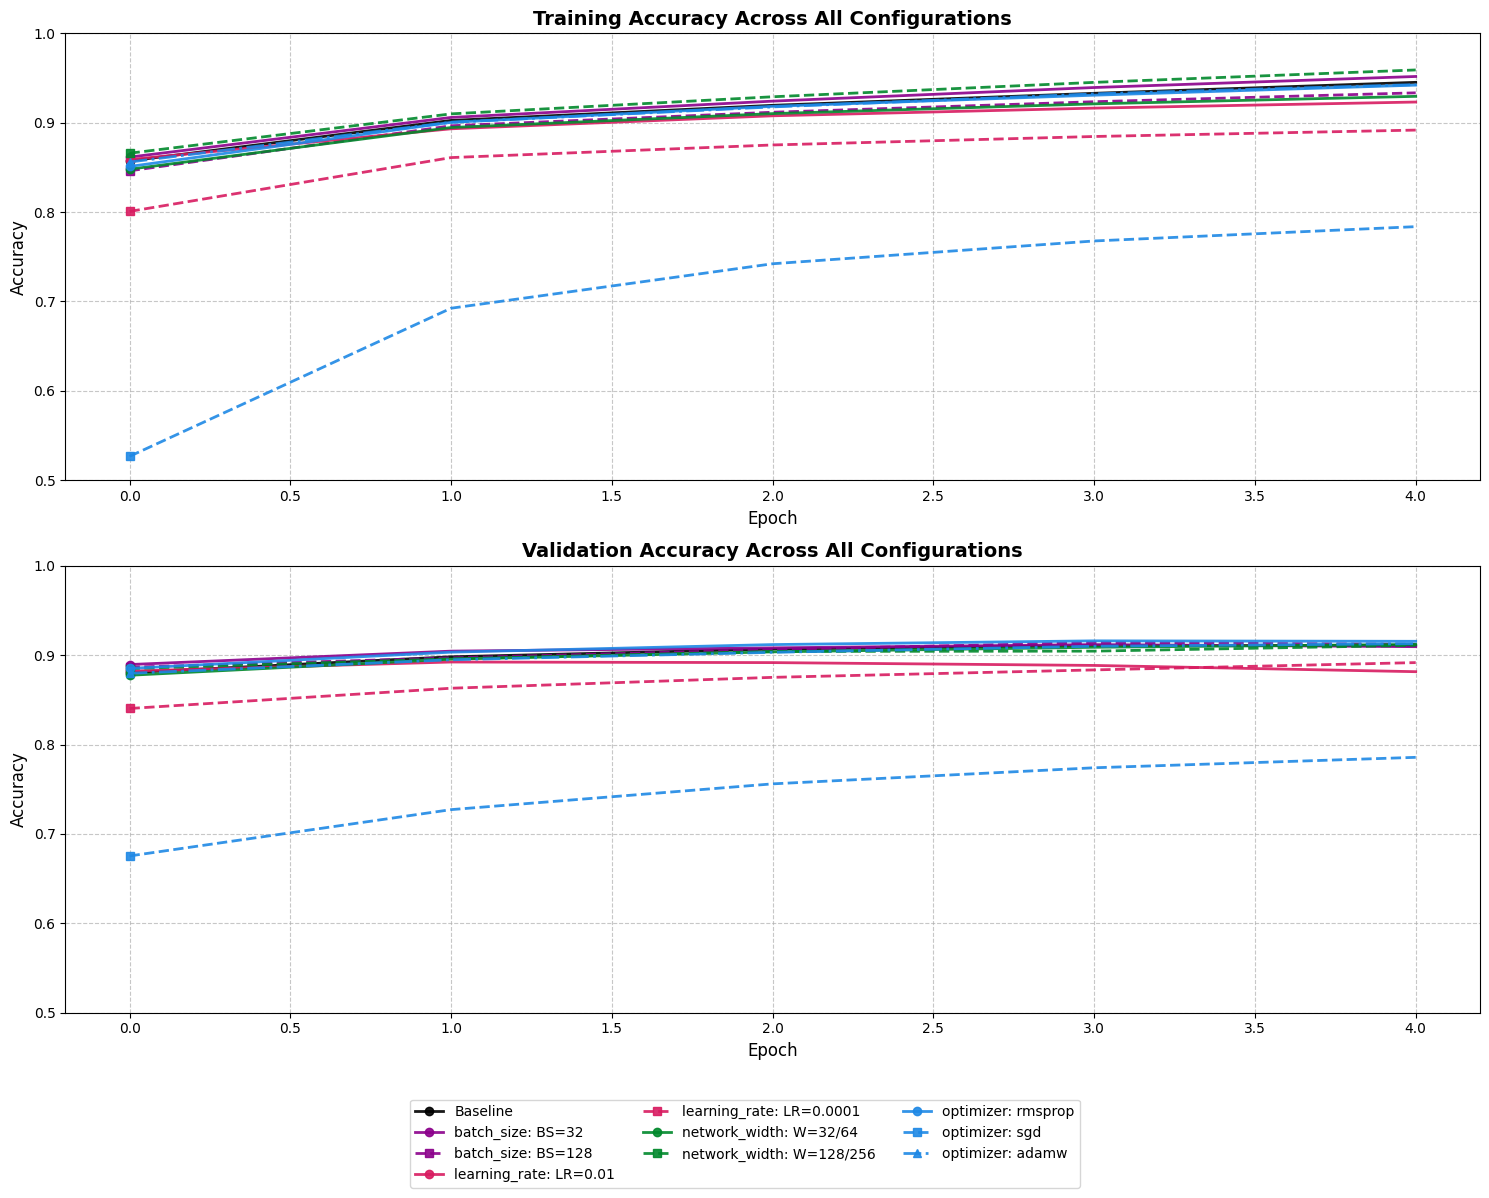

Experiments completed!


In [21]:
# Also create an overall summary plot for comparison (with improved visualization)
plt.figure(figsize=(15, 12))

# Group results by experiment group with expanded color palette and better distinction
all_groups = set(r['config']['experiment_group'] for r in results)

# Define a more distinctive color palette
group_colors = {
    'baseline': '#000000',      # Black
    'optimizer': '#1E88E5',     # Blue
    'learning_rate': '#D81B60', # Magenta/Red
    'network_width': '#00882B', # Green
    'batch_size': '#8B008B',    # Purple
}

# Define distinctive line styles for each experiment within groups
line_styles = ['-', '--', '-.', ':']

# Define distinctive markers
markers = ['o', 's', '^', 'D', 'v', '*', 'X', 'P']

# Training accuracy plot
plt.subplot(2, 1, 1)
legend_handles = []

for group_idx, group in enumerate(sorted(all_groups)):
    group_results = [r for r in results if r['config']['experiment_group'] == group]

    # Use color, line style, and marker to differentiate
    for i, r in enumerate(group_results):
        # Determine appropriate line style and marker
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]

        # Use a more distinctive color scheme
        base_color = group_colors.get(group, 'gray')

        # Generate descriptive label
        if group == 'baseline':
            label = "Baseline"
        else:
            param_desc = ""
            if group == 'optimizer':
                param_desc = f"{r['config']['optimizer']}"
            elif group == 'learning_rate':
                param_desc = f"LR={r['config']['learning_rate']}"
            elif group == 'batch_size':
                param_desc = f"BS={r['config']['batch_size']}"
            elif group == 'network_width':
                param_desc = f"W={r['config']['filters']}/{r['config']['dense_units']}"
            label = f"{group}: {param_desc}"

        # Plot with both line style and markers for better distinction
        # Use marker every 5 points to avoid crowding
        line = plt.plot(r['train_accuracy'], label=label, color=base_color,
                  linestyle=linestyle, marker=marker, markevery=5,
                  alpha=0.9, linewidth=2, markersize=6)

        legend_handles.append(line[0])

plt.title("Training Accuracy Across All Configurations", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.5, 1.0)  # Adjust y-axis range for better visualization if appropriate

# Validation accuracy plot
plt.subplot(2, 1, 2)

for group_idx, group in enumerate(sorted(all_groups)):
    group_results = [r for r in results if r['config']['experiment_group'] == group]

    for i, r in enumerate(group_results):
        # Determine appropriate line style and marker
        linestyle = line_styles[i % len(line_styles)]
        marker = markers[i % len(markers)]

        # Use a more distinctive color scheme
        base_color = group_colors.get(group, 'gray')

        # Generate descriptive label
        if group == 'baseline':
            label = "Baseline"
        else:
            param_desc = ""
            if group == 'optimizer':
                param_desc = f"{r['config']['optimizer']}"
            elif group == 'learning_rate':
                param_desc = f"LR={r['config']['learning_rate']}"
            elif group == 'batch_size':
                param_desc = f"BS={r['config']['batch_size']}"
            elif group == 'network_width':
                param_desc = f"W={r['config']['filters']}/{r['config']['dense_units']}"
            label = f"{group}: {param_desc}"

        # Plot with both line style and markers for better distinction
        plt.plot(r['val_accuracy'], label=label, color=base_color,
                 linestyle=linestyle, marker=marker, markevery=5,
                 alpha=0.9, linewidth=2, markersize=6)

plt.title("Validation Accuracy Across All Configurations", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0.5, 1.0)  # Adjust y-axis range for better visualization if appropriate

# Add a single legend for both plots at the bottom
plt.figlegend(handles=legend_handles, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make room for legend
plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')  # Save high-resolution image
plt.show()

print("Experiments completed!")